In [17]:
# analyze the confusion map
total=1555
p=1+538+2+206+171+1+44+37+187+87
p/total

0.8192926045016077

In [18]:
p+=25+25+11+5+84+16
p/total

0.9260450160771704

In [19]:
import sys
sys.path.append('../url/code/tool/')
from feature import get_feature

In [20]:
get_feature('./url/pure_abnormal/pure_abnormal_train.csv','./url_feature_train.csv')
get_feature('./url/pure_abnormal/pure_abnormal_test.csv','./url_feature_test.csv')

In [21]:
import torch
text_feature=torch.load('features/features.pt')
text_feature=text_feature.numpy()

In [22]:
import pandas as pd
url_feature=pd.read_csv('url_feature_train.csv')
len(url_feature)
url_feature=url_feature.iloc[:,:7].to_numpy()

In [52]:
# feature concat
import numpy as np
features=np.concatenate([text_feature,url_feature],axis=-1)
features.shape

(6140, 775)

## MLP Classification

In [24]:
labels_test=pd.read_csv('./features/features_labels_test.csv')
labels_test=labels_test['label']

text_features=torch.load('./features/features_test.pt')
url_features=pd.read_csv('./url_feature_test.csv')
url_features=url_features.iloc[:,:7].to_numpy()
url_features=torch.tensor(url_features)
features_test=torch.concat([text_features,url_features],dim=-1)

In [25]:
from torch.utils.data import DataLoader
def eval_on_test(net,features,labels):
    net.eval()
    length=len(labels)
    labels=DataLoader(labels,batch_size=64)
    features=DataLoader(features,batch_size=64)
    sum=0
    for feature,label in zip(features,labels):
        output=net(feature)
        predict=torch.argmax(output,dim=-1)
        sum+=(predict==label).sum()
    print(f"accuracy on test :{sum}/{length}={sum/length}")


In [51]:
label_data=pd.read_csv('./features/features_labels.csv')
text_features=torch.load('features/features.pt')
url_features=pd.read_csv('url_feature_train.csv')
url_features=url_features.iloc[:,:7].to_numpy()
url_features=torch.tensor(url_features)
features_data=torch.concat([text_features,url_features],dim=-1)

In [27]:
def train(lr,batch_size,epoches,features_data,labels_data,test_features,test_labels,over_write=False):
    # load data
    labels=DataLoader(labels_data,batch_size=batch_size)
    features=DataLoader(features_data,batch_size=batch_size)
    # features_data=text_features
    print(features_data.shape)
    # net and solver
    from mlp import mlp
    import os
    net=mlp(in_features=features_data.shape[-1])
    if os.path.exists('./classifier_model/mlp.pkl') and not over_write:
        state_dict=torch.load('./classifier_model/mlp.pkl')
        net.load_state_dict(state_dict=state_dict)
    criterion=torch.nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(net.parameters(),lr=lr)
    # train
    loss_list=[]
    for e in range(epoches):
        epoch_loss=[]
        for label,feature in zip(labels,features):
            net.train()
            output=net(feature)
            loss=criterion(output,label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
        eval_on_test(net,features=test_features,labels=test_labels)
        mean_loss=np.array(epoch_loss).mean()
        loss_list.append(mean_loss)
        print(f'epoch {e+1} loss: {mean_loss}')
    loss_log=pd.DataFrame(loss_list,columns=['loss'])
    if os.path.exists('./log/loss.csv') and not over_write:
        f=pd.read_csv('./log/loss.csv')
        loss_log=pd.concat([f,loss_log],axis=0)
    loss_log.to_csv('./log/loss.csv',index=None)
    torch.save(net.state_dict(),'./classifier_model/mlp.pkl')


就像下面的实验结果一样，综合利用text和url特征直接多分类，对于提高正确率没有什么用

In [28]:
train(batch_size=32,lr=1e-6,epoches=5,over_write=False)

TypeError: train() missing 4 required positional arguments: 'features_data', 'labels_data', 'test_features', and 'test_labels'

### 按层次进行分类
2、4、6、8先视作一组，再对组内进行多分类。

In [29]:
label=pd.read_csv('./features/features_labels.csv')
test_label=pd.read_csv('./features/features_labels_test.csv')
idx1=(label['label']==2)|(label['label']==4)|(label['label']==6)|(label['label']==8)
idx2=(test_label['label']==2)|(test_label['label']==4)|(test_label['label']==6)|(test_label['label']==8)
label[idx1].value_counts()

label
2        2406
6        1099
4         886
8         291
dtype: int64

In [31]:
sub_features=torch.tensor(features[idx1],dtype=torch.float32)
print(sub_features.dtype)
t=label[idx1]['label']
sub_labels=torch.tensor(t.to_numpy())
print(sub_labels.dtype)
sub_test_labels=torch.tensor(labels_test[idx2].to_numpy())
print(sub_test_labels.dtype)
sub_test_features=features_test[idx2]
print(sub_test_features.dtype)

torch.float32
torch.int64
torch.int64
torch.float32


In [32]:
train(batch_size=32,lr=1e-6,features_data=sub_features,labels_data=sub_labels,test_features=sub_test_features,test_labels=sub_test_labels, epoches=5,over_write=False)

torch.Size([4682, 775])
accuracy on test :969/1175=0.8246808648109436
epoch 1 loss: 0.22864239344842174
accuracy on test :969/1175=0.8246808648109436
epoch 2 loss: 0.2298972017708279
accuracy on test :969/1175=0.8246808648109436
epoch 3 loss: 0.2330140878959578
accuracy on test :969/1175=0.8246808648109436
epoch 4 loss: 0.22920936221877733
accuracy on test :969/1175=0.8246808648109436
epoch 5 loss: 0.23102513130526153


In [62]:
import matplotlib.pyplot as plt
def draw_confusion_matrix(label,pred):
    # plt.clf()
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    c=confusion_matrix(label, pred)
    labels=list(set(label))
    # labels.sort()
    sns.heatmap(data=c,annot=True,fmt='g',xticklabels=labels,yticklabels=labels)
    plt.show()
    # plt.savefig('./confusion_matrix.png',dpi=720)

In [34]:
from mlp import mlp
net=mlp(in_features=775)
st=torch.load('./classifier_model/mlp.pkl')
net.load_state_dict(st)
output=net(sub_test_features)
predict=torch.argmax(output,dim=-1)
# draw_confusion_matrix(predict,sub_test_labels)
predict.shape
sub_test_labels.shape

torch.Size([1175])

In [35]:
a=pd.DataFrame(predict,columns=['label'])
a.value_counts()

label
2        607
4        258
6        247
8         63
dtype: int64

In [36]:
b=pd.DataFrame(sub_test_labels,columns=['label'])
b.value_counts()

label
2        594
6        274
4        234
8         73
dtype: int64

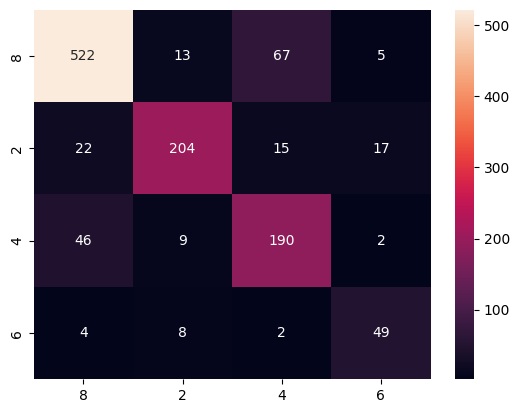

In [63]:
a=list(predict.detach().numpy())
b=list(sub_test_labels.detach().numpy())
draw_confusion_matrix(a,b)

### 逻辑回归

In [37]:
from sklearn.linear_model import LogisticRegression
LR=LogisticRegression(max_iter=2000)

In [38]:
wlb=pd.read_csv('./features/features_labels.csv')
wtlb=pd.read_csv('./features/features_labels_test.csv')

idx=(wlb['label']==2)|(wlb['label']==6)|(wlb['label']==4)|(wlb['label']==8)
i26=(wlb['label']==2)|(wlb['label']==6)
i48=(wlb['label']==4)|(wlb['label']==8)
tidx=(wtlb['label']==2)|(wtlb['label']==6)|(wtlb['label']==4)|(wtlb['label']==8)
ti26=(wtlb['label']==2)|(wtlb['label']==6)
ti48=(wtlb['label']==4)|(wtlb['label']==8)
lb26=wlb[i26].copy()
lb48=wlb[i48].copy()
lb=wlb[idx].copy()
tlb26=wtlb[ti26].copy()
tlb48=wtlb[ti48].copy()
tlb=wtlb[tidx].copy()

In [39]:
lb['label'].value_counts()
lidx1=(lb['label']==4)|(lb['label']==8)
lidx2=(lb['label']==2)|(lb['label']==6)
lb[lidx1]=4
lb[lidx2]=2
ridx1=(tlb['label']==4)|(tlb['label']==8)
ridx2=(tlb['label']==2)|(tlb['label']==6)
tlb[ridx1]=4
tlb[ridx2]=2

In [40]:
feature=features[idx]
LR.fit(feature,lb)

/Users/YZY/opt/anaconda3/envs/pytorch_cpu/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=2000)

In [41]:
LR.score(features_test[tidx],tlb)

0.9438297872340425

In [54]:
lr26=LogisticRegression(max_iter=3000)
lr26.fit(features[i26],lb26)
lr26.score(features_test[ti26],tlb26)

/Users/YZY/opt/anaconda3/envs/pytorch_cpu/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8513824884792627

In [55]:
lr48=LogisticRegression(max_iter=3000)
lr48.fit(features[i48],lb48)
lr48.score(features_test[ti48],tlb48)

/Users/YZY/opt/anaconda3/envs/pytorch_cpu/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9022801302931596

In [56]:
div24=LR.predict(features_test[tidx])
g2=div24==2
g4=div24==4

In [57]:
div26=lr26.predict(features_test[tidx][g2])
div48=lr48.predict(features_test[tidx][g4])
div24[g2]=div26
div24[g4]=div48

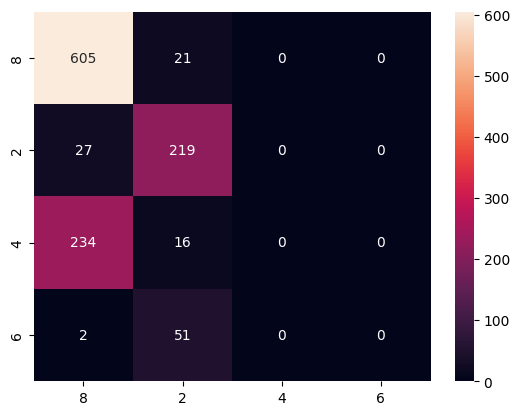

In [66]:
draw_confusion_matrix(div24,tlb)

In [ ]:
import pickle
pickle.dump(lr26,'./lr26.pkl')

NameError: name 'lr26' is not defined